<a href="https://colab.research.google.com/github/urness/CS167Fall2025/blob/main/Day07_Weighted_kNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS167: Day07
##Weighted kNN

#### CS167: Machine Learning, Fall 2025


## Before we get started, let's load in our datasets:
Make sure you change the path to match your Google Drive.


In [ ]:
import pandas as pd
import numpy as np

# The first step is to mount your Google Drive to your Colab account.
#You will be asked to authorize Colab to access your Google Drive. Follow the steps they lead you.

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#import the data:
#make sure the path on the line below corresponds to the path where you put your dataset.
iris_df = pd.read_csv('/content/drive/MyDrive/CS167/datasets/irisData.csv')

## 💻 Programming Exercise (REVIEW)

Normalize each of the predictor columns in the iris dataset.

Use the knn function (with k=5) to predict the species of the following
```
new_iris = {}
new_iris['petal length'] = 5.1
new_iris['sepal length'] = 7.2
new_iris['petal width'] = 1.5
new_iris['sepal width'] = 2.5
```

> Note: you need a way to transform the new reading (the specimen) that you will make the precition on so that the new one and the training data will all be on the same sclae. How can you do that?


In [ ]:
#petal_length
pl_mean = iris_df['petal length'].mean()
pl_std = iris_df['petal length'].std()

#petal_width
pw_mean = iris_df['petal width'].mean()
pw_std = iris_df['petal width'].std()

#sepal_length
sl_mean = iris_df['sepal length'].mean()
sl_std = iris_df['sepal length'].std()

#sepal_width
sw_mean = iris_df['sepal width'].mean()
sw_std = iris_df['sepal width'].std()

#make a copy of the original dataframe
normalized_iris_df = iris_df.copy()

#replace column with each entry's z-score
normalized_iris_df['petal length'] = (normalized_iris_df['petal length'] - pl_mean)/pl_std
normalized_iris_df['petal width'] = (normalized_iris_df['petal width'] - pw_mean)/pw_std
normalized_iris_df['sepal length'] = (normalized_iris_df['sepal length'] - sl_mean)/sl_std
normalized_iris_df['sepal width'] = (normalized_iris_df['sepal width'] - sw_mean)/sw_std
normalized_iris_df.head()

In [ ]:
def kNN(specimen, data, k):
    # 1. calculate distances
    data['distance_to_new'] = np.sqrt(
     (specimen['petal length'] - data['petal length'])**2
    +(specimen['sepal length'] - data['sepal length'])**2
    +(specimen['petal width'] - data['petal width'])**2
    +(specimen['sepal width'] - data['sepal width'])**2)

    # 2. sort
    sorted_data = data.sort_values(['distance_to_new'])

    # 3. predict
    prediction = sorted_data.iloc[0:k]['species'].mode()[0]

    return prediction

In [ ]:
#classify this iris
new_iris = {}
new_iris['petal length'] = 5.1
new_iris['sepal length'] = 7.2
new_iris['petal width'] = 1.5
new_iris['sepal width'] = 2.5

# original data
print("ORIGINAL DATA:", kNN(new_iris, iris_df, 10))

#normalize the new iris
normalized_new_iris = {}
normalized_new_iris['petal length'] = (5.1 - pl_mean)/pl_std
normalized_new_iris['sepal length'] = (7.2 - sl_mean)/sl_std
normalized_new_iris['petal width'] = (1.5 - pw_mean)/pw_std
normalized_new_iris['sepal width'] = (2.5 - sw_mean)/sw_std

# normalized data
print("NORMALIZED DATA:", kNN(normalized_new_iris, normalized_iris_df, 10))

ORIGINAL DATA: Iris-versicolor
NORMALIZED DATA: Iris-virginica


#New Material

## First, let's learn a few new Pandas functions!
- `display()`
- `index()`

In [ ]:
# let's construct a Series
colors = pd.Series(
    {
        "Red": 23.42,
        "Blue": 42.23,
        "Green": 12.34
    },
    name="colors"
)
display(colors) # note the use of display (not print)

In [ ]:
# sort the values --
sorted_results = colors.sort_values(ascending=False)
display(sorted_results)


In [ ]:
# get the value of the first element
print(sorted_results.iloc[0])

In [ ]:
# get the label of the first element
print(sorted_results.index[0])

## Are all neighbors created equal?

The way we've learned kNN so far, each neighbor gets an equal vote in the decision of what to predict.

Do we see any problems with this? If so, what?

<div>
<img src="https://analytics.drake.edu/~reza/teaching/cs167_sp25/notes/images/day04_wknn_motivation.png" width = 500/>
</div>

Should neighbors that are closer to the new instance get a larger share of the vote?

# Weighted k-NNN Intuition:

In weighted kNN, the nearest k points are given a weight, and the weights are grouped by the target variable. The class with the largest sum of weights will be the class that is predicted.

The intuition is to give more weight to the points that are nearby and less weight to the points that are farther away.
- distance-weighted voting

In w-kNN, we want to predict the target variable with the most weight, where the weight is defined by the inverse distance function.

## $w_{q,i} = \frac{1}{d(x_q, x_i)^2}$

> In English, you can read that as the __weight__ of a training example is equal to 1 divided by the distance between the new instance and the training example squared.

## A w-kNN Example: Step 1

Start by calculating the distance between the new example ('X'), and each of the other training examples:

<div>
<img src="https://analytics.drake.edu/~reza/teaching/cs167_sp25/notes/images/day04_wknn_ex.png"/>
</div>

## A w-kNN Example: Step 2

Then, __calculate the weight___ of each training example using the inverse distance squared.

<div>
<img src="https://analytics.drake.edu/~reza/teaching/cs167_sp25/notes/images/day04_wknn_ex1.png"/>
</div>

## A w-kNN Example: Step 3

Find the k closest neighbors--let's assume `k=3` for this example:
<div>
<img src="https://analytics.drake.edu/~reza/teaching/cs167_sp25/notes/images/day04_wknn_ex2.png"/>
</div>

Then, sum the weights for each possible class:
- __orange__: $1$
- __blue__: $1/16 + 1/9 = 0.115$

### What would a __normal 3NN__ predict? Weighted 3NN?

## Let's write some code:

Write a new function `weighted_knn()`

Pass the iris measurements (specimen), data frame, and k as parameters and return the precited class.

In [ ]:
def weighted_kNN(specimen, data, k):

    # step 1. calculate the distances from 'specimen' to all other samples in 'data'
    data['distance_to_new'] = np.sqrt(
    (specimen['petal length'] - data['petal length'])**2
    +(specimen['sepal length'] - data['sepal length'])**2
    +(specimen['petal width'] - data['petal width'])**2
    +(specimen['sepal width'] - data['sepal width'])**2)

    # step 2 calcuate the weights (remember, weights are 1/d^2)
    #data['weights'] = YOUR CODE HERE

    # step 3. find the k closest neighbors as follows
    # step 3a. sort the data and take the first k samples as neighbors
    sorted_data = data.sort_values(['distance_to_new'])
    neighbors = data.iloc[0:k]

    # step 3b. use groupby to sum the weights of each species in the closest k
    # YOUR CODE HERE

    # step 4. return the class that has the largest sum of weight.
    # YOUR CODE HERE


The following section should be a *sanity check* that your implementation of `weighted_kNN` is correct. The output should look like the following:

<div>
<img src=" https://analytics.drake.edu/~urness/CS167/CS167Sept16.png"/>
</div>


In [ ]:
#load the data
iris_df = pd.read_csv('/content/drive/MyDrive/CS167/datasets/irisData.csv')

#create a new specimen to classify
new_iris = {}
new_iris['petal length'] = 5.1
new_iris['sepal length'] = 7.2
new_iris['petal width'] = 1.5
new_iris['sepal width'] = 2.5

# call the function
result = weighted_kNN(new_iris,iris_df,3)
print("weighted kNN with not normalized data; k=3 --- ", result)

# let's display the top 3 results, with distances and weights
display(iris_df.iloc[0:3][['species','distance_to_new', 'weights']])

#In-Class Exercise:
For k=3, what is the prediction of iris dataset for the iris below for the options of
*   unweighted kNN, NOT normalized
*   unweighted kNN, normalized
*   WEIGHTED kNN, NOT normalized
*   WEIGHTED kNN, normalized

```
new_iris = {}
new_iris['petal length'] = 5.1
new_iris['sepal length'] = 7.2
new_iris['petal width'] = 1.5
new_iris['sepal width'] = 2.5
```





## Use these tables to keep track of your predictions:
### `k=3`
|                    | **not normalized** | **normalized** |
|--------------------|--------------------|----------------|
| **unweighted kNN** |                    |               |
| **weighted kNN**   |                    |                |

### `k=5`

|                    | **not normalized** | **normalized** |
|--------------------|--------------------|----------------|
| **unweighted kNN** |                    |                |
| **weighted kNN**   |                    |                |

In [ ]:
new_iris = {}
new_iris['petal length'] = 5.1
new_iris['sepal length'] = 7.2
new_iris['petal width'] = 1.5
new_iris['sepal width'] = 2.5

# 💬 Discussion Question

Should we __always__ normalize our data? Why or why not?

When does it make sense to normalize? When might it make more sense not to?



---



# Graphs!

In [ ]:
#import the data:
#make sure the path on the line below corresponds to the path where you put your dataset.
vehicles_df = pd.read_csv('/content/drive/MyDrive/CS167/datasets/vehicles.csv')

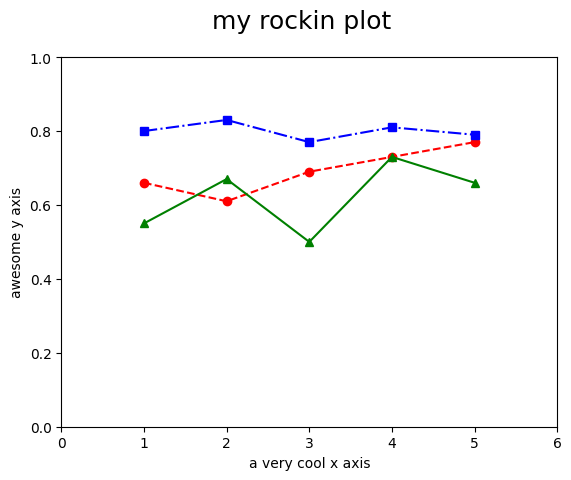

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

#define our data
xvals = [1,2,3,4,5]
series1 = [0.66,0.61,0.69,0.73,0.77]
series2 = [0.8,0.83,0.77,0.81,0.79]
series3 = [0.55,0.67,0.5,0.73,0.66]

#add titles to axis and graph
plt.suptitle('my rockin plot', fontsize=18)
plt.xlabel('a very cool x axis')
plt.ylabel('awesome y axis')

#plot the data
plt.plot(xvals, series1, 'ro--', label='1st series')
plt.plot(xvals, series2, 'bs-.', label='2nd series')
plt.plot(xvals, series3, 'g^-', label='3rd series')
plt.axis([0,6,0,1]) #[x_min, x_max, y_min, y_max]
plt.show()

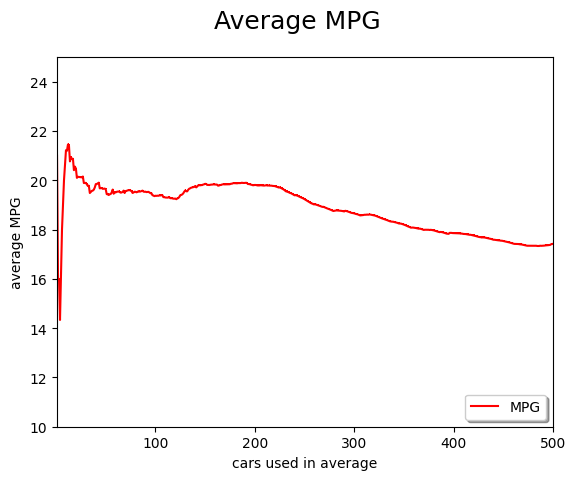

In [ ]:
gas_vehicles = vehicles_df[vehicles_df['fuelType']=='Regular']

# a silly function that returns the average MPG for the first k cars in the df
def getAverageMPG(data, k):
    return data["comb08"].iloc[0:k].mean()

number_of_points = 500

#populate the series list
series = []
for i in range(1, number_of_points):
    val = getAverageMPG(gas_vehicles, i)
    series.append(val)

#plot it!
xvals = range(1, number_of_points)
plt.suptitle('Average MPG', fontsize=18)
plt.xlabel('cars used in average')
plt.ylabel('average MPG')
plt.plot(xvals, series, 'r,-', label='MPG')
plt.legend(loc='lower right', shadow=True)
plt.axis([1, number_of_points, 10,25])
plt.show()

#Exercise
*   change the number of points to 20
*   change the line to green triangles
*   also plot the median (using red dots)